In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from optbinning import OptimalBinning

(CVXPY) Sep 17 10:08:21 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 17 10:08:21 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [4]:
pd.options.display.max_colwidth=200

In [5]:
pd.options.display.max_rows = 100

# Functions

In [6]:
def prepare_best_split(df, na_col):
    na_series = df[na_col].isna()
    na_count = na_series.sum()
    non_na_count = len(na_series) - na_count
    return na_count, non_na_count

In [7]:
def bin_and_score(var, col, na_col, pos_count, neg_count, min_tpr=0.1, max_fpr=0.5, max_n_bins=3):
    var_type = "numerical" if var in num_cols else "categorical"
    #todo: check if there's a perfect score which leads to an error
    optb = OptimalBinning(name=var, dtype=var_type, max_n_bins=max_n_bins)
    optb.fit(col, na_col)
    table = optb.binning_table.build()
    table.drop(table.tail(1).index,inplace=True)
    table["Column"] = var
    table["type"] = var_type
    table["negate"] = np.where(table["WoE"] > 0, True, False)
    table["Total Events"] = pos_count
    table["Total Non-Events"] = neg_count
    table["Event"] = np.where(table["WoE"] > 0, pos_count-table["Event"], table["Event"])
    table["Non-event"] = np.where(table["WoE"] > 0, neg_count-table["Non-event"], table["Non-event"])
    prop_pos = table["Event"] / pos_count
    prop_neg = table["Non-event"] / neg_count
    new_woe = prop_neg / prop_pos
    new_woe = np.log(new_woe)
    #TODO: go over this "neg" / "pos"
    table["WoE"] = new_woe
    #table["WoE"] = np.where(table["WoE"] > 0, new_woe, table["WoE"])
    table["TPR"] = prop_pos
    table["FPR"] = prop_neg
    table = table.query(f"(WoE != 0) & (TPR >= {min_tpr}) & (FPR <= {max_fpr})").copy().reset_index(drop=True)
    return table[["Column", "Bin", "WoE", "Event", "Non-event", "TPR", "FPR", "type", "negate"]]

In [8]:
def bin_to_query(row):
    col, bin_val, var_type, negate = row['Column'], row['Bin'], row["type"], row["negate"]
    
    if isinstance(bin_val, str):
        if bin_val == 'Missing':
            if negate:
                return f"{col}.notna()"
            else:
                return f"{col}.isna()"
            
        elif bin_val == 'Special': #TODO: fix
            return f"special_condition({col})"

    if var_type == "categorical":
        val = ', '.join([f"'{str(x)}'" for x in bin_val])
        if len(bin_val) > 1:
            if negate:
                return f"{col} not in ([{val}])"
            else:
                return f"{col} in ([{val}])"
        else:
            if negate:
                return f"{col} != {val}"
            else:
                return f"{col} == {val}"
        
    #Numeric
    lower, upper = bin_val.split(',')
    q1=q2=""    
    if '[' in lower:
        q1 += f"{col} >= {lower[1:].strip()}"
    elif '(' in lower:
        if '-inf' not in lower:
            q1 += f"{col} > {lower[1:].strip()}"
    if ']' in upper:
        q2 += f"{col} <= {upper[:-1].strip()}"
    elif ')' in upper:
        if 'inf' not in upper:
            q2 += f"{col} < {upper[:-1].strip()}"
    
    if q1 and q2:
        if negate:
            return f"~({q1} & {q2})"
        else:
            return f"{q1} & {q2}"
    
    if negate:
        if q1:
            if ">=" in q1:
                return q1.replace(">=", "<")
            else: #has '>'
                return q1.replace(">", "<=")
        elif q2:
            if "<=" in q2:
                return q2.replace("<=", ">")
            else: #has '>'
                return q2.replace("<", ">=")
    else:
        return q1 + q2

# OptBin Algorithm

In [9]:
def query_from_rules(rules):
    final_rule_query = " & ".join([f"({d['Query']})" for rule in rules])

In [10]:
def dataset_by_current_rules(dataset, current_rules):
    query = query_from_rules(current_rules)
    try:
        df_sub = dataset.query(query)
    except:
        print(query)
        print(dataset)
    df_sub.drop(column, axis=1, inplace=True)
    return df_sub

In [11]:
class RuleNode:
    def __init__(self, col, col_bin, score, event_count, non_event_count, tpr, fpr, col_type, negate, query):
        self.col = col
        self.col_bin = col_bin
        self.score = score
        self.event_count = event_count
        self.non_event_count = non_event_count
        self.tpr = tpr
        self.fpr = fpr
        self.col_type = col_type
        self.negate = negate
        self.query = query
        self.children = []
    
    @classmethod
    def parse_row(cls, row):
        return cls(
            col=row["Column"],
            col_bin=row["Bin"],
            score=row["WoE"],
            event_count=row["Event"],
            non_event_count=row["Non-event"],
            tpr=row["TPR"],
            fpr=row["FPR"],
            col_type=row["type"],
            negate=row["negate"],
            query=row["Query"]
        )
    
    def add_child(self, child):
        self.children.append(child)
    
    def get_query(self):
        return self.query
    
    def get_score(self):
        return self.score
    
    def show(self):
        print(f"Column: {self.col}")
        print(f"Bin: {self.col_bin}")
        print(f"Score: {self.score}")
        print(f"Event Count: {self.event_count}")
        print(f"Non-Event Count: {self.non_event_count}")
        print(f"TPR: {self.tpr}")
        print(f"FPR: {self.fpr}")
        print(f"Column Type: {self.col_type}")
        print(f"Negated: {self.negate}")
        print(f"Query: {self.query}")
        
    def __eq__(self, other):
        if not isinstance(other, RuleNode):
            return False
        return self.query == other.query

    def __hash__(self):
        return hash(self.query)  # Hash based on the properties that define equality

    def __str__(self):
        return f"RuleNode(Column: {self.col}, Bin: {self.col_bin}, Score: {self.score}, TPR: {self.tpr}, FPR: {self.fpr})"

    def show_tree(self, level=0):
        print("  " * level + str(self))
        for child in self.children:
            child.show_tree(level + 1)

In [12]:
class RulePath:
    def __init__(self):
        self.nodes = []
    
    def add_node(self, node: RuleNode):
        self.nodes.append(node)
        
    def remove_node(self):
        self.nodes.pop()
    
    def get_node_at_depth(self, depth: int) -> RuleNode:
        return self.nodes[depth] if depth < len(self.nodes) else None
    
    def extract_path_up_to_k(self, k):
        truncated_path = RulePath()
        truncated_path.nodes = self.nodes[:k]
        return truncated_path
    
    def show_path_up_to_depth(self, depth: int):
        truncated_nodes = self.nodes[:depth+1]
        #truncated_path_str = " -> ".join(str(node) for node in truncated_nodes)
        #print(f"Path up to depth {depth}: {truncated_path_str}")

        for i, node in enumerate(truncated_nodes):
            print(f"\nNode at depth {i}:")
            node.show()  # Assuming RuleNode has a 'show' method to display its properties
    def get_rules(self):
        return self.nodes
    
    def get_query(self):
        return " & ".join([f"({node.query})" for node in self.nodes]) 
    
    def get_path_cols(self):
        return [node.col for node in self.nodes]
    
    def get_score(self):
        if len(self.nodes) == 0:
            return None
        else:
            return self.nodes[-1].score
    
    def get_depth(self):
        return len(self.nodes)
    
    def show(self):
        #self.show_path_up_to_depth(len(self.nodes) - 1)
        print(f"Query: {self.get_query()}, Score: {self.get_score()}")
    
    def __eq__(self, other):
        if not isinstance(other, RulePath):
            return False
        
        if self.get_depth() != other.get_depth():
            return False
        
        depth = self.get_depth()
        for i in range(depth):
            if self.nodes[i] != other.nodes[i]:
                return False

        return True

In [13]:
def dataset_by_current_path(df, path):
    query = path.get_query()
    if len(query) == 0:
        return df
    
    try:
        df_sub = df.query(query).copy()
    except:
        print(query)
        print(df)
        
    cols = path.get_path_cols()
    cols = list(set(cols).intersection(df_sub.columns))
    df_sub.drop(cols, axis=1, inplace=True)
    return df_sub

In [14]:
def get_features_without_label(df, label):
    return [col for col in df.columns if col != label]

In [15]:
def get_all_bins(df, label, pos_series, pos_count, neg_count, min_tpr=0.1, max_fpr=0.3, max_n_bins=3, test=False):
    features = get_features_without_label(df, label)
    dfs = [bin_and_score(var, df[var], pos_series, pos_count, neg_count, min_tpr, max_fpr, max_n_bins) for var in features]
    
    if any(len(df) > 0 for df in dfs):
        df_all_bins = pd.concat([df for df in dfs if len(df) > 0], ignore_index=True)
    else:
        return None
    
    df_all_bins.sort_values("WoE", ascending=True, inplace=True)
    df_all_bins['Query'] = df_all_bins.apply(bin_to_query, axis=1)

    if test:
        for idx, row in df_all_bins.iterrows():
            df.query(row["Query"])

    df_all_bins.drop_duplicates(subset='Query', inplace=True)
    
    return df_all_bins

In [16]:
def candidates_for_current_path(df, path, label, pos_series, pos_count, neg_count, min_tpr=0.1, max_fpr=0.3, max_n_bins=3, **kwargs):
    # This will return a DataFrame or None
    df_all_bins = get_all_bins(df, label, pos_series, pos_count, neg_count, min_tpr, max_fpr, max_n_bins)
    
    if df_all_bins is None:
        return None
    
    # Convert rows of df_all_bins into RuleNode objects
    rule_nodes = [RuleNode.parse_row(row) for _, row in df_all_bins.iterrows()]
    
    return rule_nodes

In [17]:
def calc_counts(pos_series):
    pos_count = pos_series.sum()
    neg_count = len(pos_series) - pos_count
    return pos_count, neg_count

In [18]:
def is_score_improved(cur_score, new_score, higher_is_better=True):
    if cur_score is None:
        return True
    
    if higher_is_better:
        return new_score > cur_score
    else:
        return new_score < cur_score

In [19]:
def create_pos_series_by_config(dataset, config):
    func = config["pos_series_func"]
    label = config["label"]
    return func(dataset, label)

In [20]:
def expand_paths(dataset, active_paths, final_paths, max_depth, beam_width, config):
    if len(active_paths) == 0:
        root_path = RulePath()
        active_paths.append(root_path)
    
    if len(active_paths[0].nodes) >= max_depth:
        final_paths.extend(active_paths)
        return final_paths

    new_active_paths = []

    for current_path in active_paths:
        new_dataset = dataset_by_current_path(dataset, current_path)
        
        if new_dataset is None:
            final_paths.append(current_path)
            continue
        
        new_pos_series = create_pos_series_by_config(new_dataset, config)
        config["pos_series"] = new_pos_series
        new_rules = candidates_for_current_path(new_dataset, current_path, **config)
        
        if new_rules is None or len(new_rules) == 0:
            final_paths.append(current_path)
            continue
            
        top_new_rules = new_rules[:beam_width]
        cur_score = current_path.get_score()
        
        for rule in top_new_rules:
            if len(rule.get_query()) <= 3:
                print(top_new_rules)
                continue
                
            if is_score_improved(cur_score, rule.score, config["higher_is_better"]):
                new_path = RulePath()
                new_path.nodes = current_path.nodes.copy()
                new_path.add_node(rule)
                new_active_paths.append(new_path)
    
    if len(new_active_paths) == 0:
        return final_paths
    
    return expand_paths(dataset, new_active_paths, final_paths, max_depth, beam_width, config)

# Iterative Code

In [21]:
def paths_to_df(paths, drop_duplicates=True):
    path_dicts = []
    
    for path in paths:
        path_dct = {}

        path_dct["query"] = path.get_query()
        path_dct["score"] = path.get_score()
        path_dct["cols"] = path.get_path_cols()
        path_dct["depth"] = path.get_depth()

        path_dicts.append(path_dct)

    # Convert the list of dictionaries to a DataFrame
    df_paths = pd.DataFrame(path_dicts)

    df_paths.drop_duplicates(subset='query', inplace=True)
    df_paths.sort_values("score", ascending=~higher_is_better, inplace=True)
    return df_paths

In [22]:
#idea: I can visualize the umap projection of the dataset and show which items are recalled by each leaf or node

In [23]:
def filter_dataset(dataset, paths):
    final_query = " | ".join([f"({path.get_query()})" for path in paths])
    return dataset.query(f"~({final_query})")

In [24]:
def get_best_path(paths, config):
    if len(paths) == 0:
        return None
    
    best_score = None
    best_path = None
    for path in paths:
        if is_score_improved(best_score, path.get_score(), config["higher_is_better"]):
            best_score = path.get_score()
            best_path = path
    return best_path

In [25]:
def exclude_existing_paths(paths, existing_paths):
    final_paths = []
    for path in paths:
        exists = False
        path_rules_set = set(path.get_rules())  # Assuming get_rules() returns the list of rules in the path
        
        for existing_path in existing_paths:
            existing_path_rules_set = set(existing_path.get_rules())
            
            # Check if the sets are equal or if path_rules_set is a subset of existing_path_rules_set
            if path_rules_set == existing_path_rules_set or path_rules_set.issubset(existing_path_rules_set):
                exists = True
                break
                
        if not exists:
            final_paths.append(path)
    return final_paths

# Read DF

# Defining Production Columns

In [26]:
user_cols = ['age', 'icu_id', 'urineoutput_apache', 'd1_heartrate_min', 'd1_spo2_min', 
             'd1_resprate_min', 'd1_sodium_max', 'bmi', 'd1_wbc_min', 'd1_temp_max']

In [27]:
autofill_cols = ['apache_4a_hospital_death_prob', 'apache_3j_bodysystem']

In [28]:
prod_cols = user_cols + autofill_cols

In [29]:
label_col = "hospital_death"

# Getting "Correct" Dataset
## Querying, Filtering Rows, Columns & Changing Values

This is where the **business logic** shines

In [30]:
raw_df = pd.read_csv("../../data/wids2020/training_v2.csv")

In [31]:
raw_df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


## Filtering Rows

In [32]:
k = 10

In [33]:
top_hospitals = raw_df["hospital_id"].value_counts().head(k).index.tolist()

In [34]:
df = raw_df[raw_df["hospital_id"].isin(top_hospitals)].copy().reset_index()

## Filtering Prod Columns

In [35]:
df = df[prod_cols + [label_col]]

In [36]:
df["apache_3j_bodysystem"] = pd.Categorical(df["apache_3j_bodysystem"])

## Define Columns

In [37]:
num_cols = df._get_numeric_data().columns

In [38]:
cat_cols = df.select_dtypes('category').columns.tolist()

In [39]:
beam_width = 2

In [40]:
#TODO: use min + top cluster

In [41]:
label = "apache_4a_hospital_death_prob"

In [42]:
label = "age"

In [43]:
pos_series = df[label].isna()
pos_count, neg_count = calc_counts(pos_series)
higher_is_better = False
config = {
    'label': label,
    'pos_series': pos_series,
    'pos_count': pos_count,
    'neg_count': neg_count,
    'min_tpr': 0.1,
    'max_fpr': 0.3,
    'higher_is_better' : higher_is_better,
    'max_n_bins' : 3,
    'pos_series_func': lambda x, col: x[col].isna(),
}

In [44]:
%%time
final_best_paths = []
active_paths = []
filtered_dataset = df.copy()
max_depth = 3  # Example max_depth
cur_depth = max_depth
reset_to_root = False

while True:
    print(f"Finding paths")
    best_paths = expand_paths(filtered_dataset, active_paths, [], max_depth=max_depth, beam_width=3, config=config)
    best_paths = exclude_existing_paths(best_paths, final_best_paths)
    best_path = get_best_path(best_paths, config)
    
    # If the best path is the same as the last active path, try shallower depths
    if (len(best_paths) == 0) or (len(active_paths) > 0 and best_path == active_paths[0]):
        print("No new best path found. Trying shallower depths.")
        parent_path = active_paths[0]
        # If we've reached the shallowest possible depth, break
        cur_depth = parent_path.get_depth()
        if cur_depth == 0:
            if reset_to_root:
                print("Already reset to root once. Exiting.")
                break

            print("Reached shallowest depth. Resetting to a new root.")
            root_path = RulePath()  # Assuming RulePath can be initialized empty
            active_paths = [root_path]
            filtered_dataset = filter_dataset(df, final_best_paths)
            reset_to_root = True
            continue

        # Try the next shallower depth
        best_path_shallower = parent_path.extract_path_up_to_k(cur_depth - 1)
        active_paths = [best_path_shallower]
        continue
    
    best_path.show()
    print(f"Adding best path to final list.")
    final_best_paths.append(best_path)
    reset_to_root = False
    
    # Filter the dataset for the next round
    filtered_dataset = filter_dataset(df, final_best_paths)
    best_path_depth = best_path.get_depth()
    # Try the next shallower depth
    parent_path = best_path.extract_path_up_to_k(best_path_depth - 1)
    active_paths = [parent_path]

Finding paths
Query: (apache_3j_bodysystem.isna()) & (apache_4a_hospital_death_prob.isna()) & (d1_heartrate_min >= 67.50), Score: -6.612516854511682
Adding best path to final list.
Finding paths
No new best path found. Trying shallower depths.
Finding paths
No new best path found. Trying shallower depths.
Finding paths
Query: (apache_3j_bodysystem.isna()) & (urineoutput_apache.isna()), Score: -2.5234303445232777
Adding best path to final list.
Finding paths
No new best path found. Trying shallower depths.
Finding paths
Query: (bmi < 25.03) & (d1_temp_max < 36.86) & (apache_4a_hospital_death_prob >= 0.09), Score: -1.583714256459977
Adding best path to final list.
Finding paths
No new best path found. Trying shallower depths.
Finding paths
Query: (bmi < 25.03) & (apache_4a_hospital_death_prob >= 0.07) & (apache_3j_bodysystem in (['Cardiovascular', 'Trauma', 'Gastrointestinal', 'Musculoskeletal/Skin'])), Score: -1.1082599919407452
Adding best path to final list.
Finding paths
No new best 

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No new best path found. Trying shallower depths.
Reached shallowest depth. Resetting to a new root.
Finding paths
[<__main__.RuleNode object at 0x7fffa28c5880>, <__main__.RuleNode object at 0x7fffa28c5820>]


/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No new best path found. Trying shallower depths.
Already reset to root once. Exiting.
CPU times: user 1min 15s, sys: 1.14 s, total: 1min 16s
Wall time: 1min 10s


In [45]:
paths_to_df(final_best_paths)

,query,score,cols,depth
0,(apache_3j_bodysystem.isna()) & (apache_4a_hospital_death_prob.isna()) & (d1_heartrate_min >= 67.50),-6.612517,"[apache_3j_bodysystem, apache_4a_hospital_death_prob, d1_heartrate_min]",3
1,(apache_3j_bodysystem.isna()) & (urineoutput_apache.isna()),-2.523430,"[apache_3j_bodysystem, urineoutput_apache]",2
2,(bmi < 25.03) & (d1_temp_max < 36.86) & (apache_4a_hospital_death_prob >= 0.09),-1.583714,"[bmi, d1_temp_max, apache_4a_hospital_death_prob]",3
5,(hospital_death >= 0.50),-1.223383,[hospital_death],1
3,"(bmi < 25.03) & (apache_4a_hospital_death_prob >= 0.07) & (apache_3j_bodysystem in (['Cardiovascular', 'Trauma', 'Gastrointestinal', 'Musculoskeletal/Skin']))",-1.108260,"[bmi, apache_4a_hospital_death_prob, apache_3j_bodysystem]",3
4,(bmi < 25.03) & (apache_4a_hospital_death_prob >= 0.11) & (d1_heartrate_min < 88.50),-0.962594,"[bmi, apache_4a_hospital_death_prob, d1_heartrate_min]",3
6,(~(icu_id >= 95.00 & icu_id < 840.50)),-0.822581,[icu_id],1
7,(apache_4a_hospital_death_prob >= 0.09) & (d1_temp_max < 37.39) & (bmi < 32.46),-0.707820,"[apache_4a_hospital_death_prob, d1_temp_max, bmi]",3


In [46]:
from graphviz import Digraph

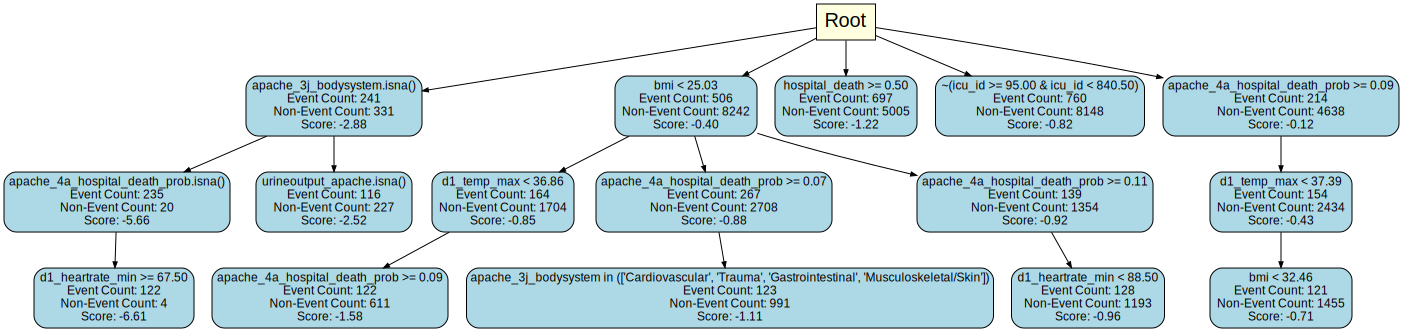

In [47]:
def add_nodes_edges(dot, node_dict, parent_id="root", parent_label="Root", depth=0, idx_in_path=0):
    for i, (query, data) in enumerate(node_dict.items()):
        current_id = f"{parent_id}_{i}_{depth}_{idx_in_path}"

        # Create the current node
        node = data['_node']
        label = f"{node.get_query()}\nEvent Count: {node.event_count}\nNon-Event Count: {node.non_event_count}\nScore: {node.get_score():.2f}"
        dot.node(current_id, label=label, fontsize='12', fontname='Helvetica', shape='box', rounded='true', fillcolor='lightblue', style='filled, rounded')

        # Connect the current node to its parent
        dot.edge(parent_id, current_id)

        # Move to the children
        add_nodes_edges(dot, data['_children'], current_id, label, depth + 1, i)

def build_shared_tree(paths):
    root = {}
    for path in paths:
        current_dict = root
        for node in path.nodes:
            query = node.get_query()
            if query not in current_dict:
                current_dict[query] = {'_node': node, '_children': {}}
            current_dict = current_dict[query]['_children']
    return root

def generate_pretty_dot(paths):
    dot = Digraph(node_attr={'style': 'filled', 'shape': 'box', 'rounded': 'true', 'fillcolor': 'lightyellow'},
                  edge_attr={'color': 'black', 'arrowsize': '0.6'},
                  graph_attr={'fontsize': '16', 'fontname': 'Helvetica'})

    dot.node("root", "Root", fontcolor='black', fontsize='20', fontname='Helvetica')
    shared_tree = build_shared_tree(paths)
    add_nodes_edges(dot, shared_tree, "root")
    return dot

# Generate and view/save the dot
dot = generate_pretty_dot(final_best_paths)

display(dot)

Improvements:
- fix bugs (division by zero, errors)
- Make it faster (parellel, faster OptBin parameters, sample(?), vectorize, ...)
- handling "'" in categories
- handle 'Special'
- Stopping Critera (if FPR is really low or WoE not increasing)
- handle division by zero on "bin_and_score"

- Add visualizations of point space to final tree
- perhaps make it clearer how the user should read the rules in order